<a href="https://colab.research.google.com/github/hermathena/Flood-Prediction/blob/main/Flood_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%%capture
!pip install catboost
!pip install pingouin
!pip install shap

In [29]:
# Data manipulation
#========================================================
import pandas as pd
import numpy as np

# Data visualization
#===========================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
#===============================================================
from scipy import stats
import pingouin as pg

# Preprocessing
#==========================================================================
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Binarizer

# Models
#============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
#===========================================================================
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

# Feature importance
import shap

# tqdm
#================================================================
from tqdm.auto import tqdm

In [1]:
from google.colab import files
uploaded = files.upload()

Saving flood.csv to flood.csv


In [9]:
data = pd.read_csv("flood.csv")

In [12]:
data.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475


In [13]:
print("==" * 35)
print(" " * 22, "Data set Information")
print("==" * 35)
print(data.info())

                       Data set Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50000 non-null  int64  
 1   TopographyDrainage               50000 non-null  int64  
 2   RiverManagement                  50000 non-null  int64  
 3   Deforestation                    50000 non-null  int64  
 4   Urbanization                     50000 non-null  int64  
 5   ClimateChange                    50000 non-null  int64  
 6   DamsQuality                      50000 non-null  int64  
 7   Siltation                        50000 non-null  int64  
 8   AgriculturalPractices            50000 non-null  int64  
 9   Encroachments                    50000 non-null  int64  
 10  IneffectiveDisasterPreparedness  50000 non-null  int64  
 11  DrainageSystems                  500

In [14]:
print("Total duplicate rows:\n")
print(data.duplicated().sum())

Total duplicate rows:

0


In [15]:
df_null_values = data.isnull().sum().to_frame().rename(columns = {0:'count'})
df_null_values['%'] = (df_null_values['count'] / len(data)) * 100
df_null_values = df_null_values.sort_values(by = '%', ascending = False)
df_null_values

,count,%
MonsoonIntensity,0,0.0
DrainageSystems,0,0.0
PoliticalFactors,0,0.0
InadequatePlanning,0,0.0
WetlandLoss,0,0.0
PopulationScore,0,0.0
DeterioratingInfrastructure,0,0.0
Watersheds,0,0.0
Landslides,0,0.0
CoastalVulnerability,0,0.0


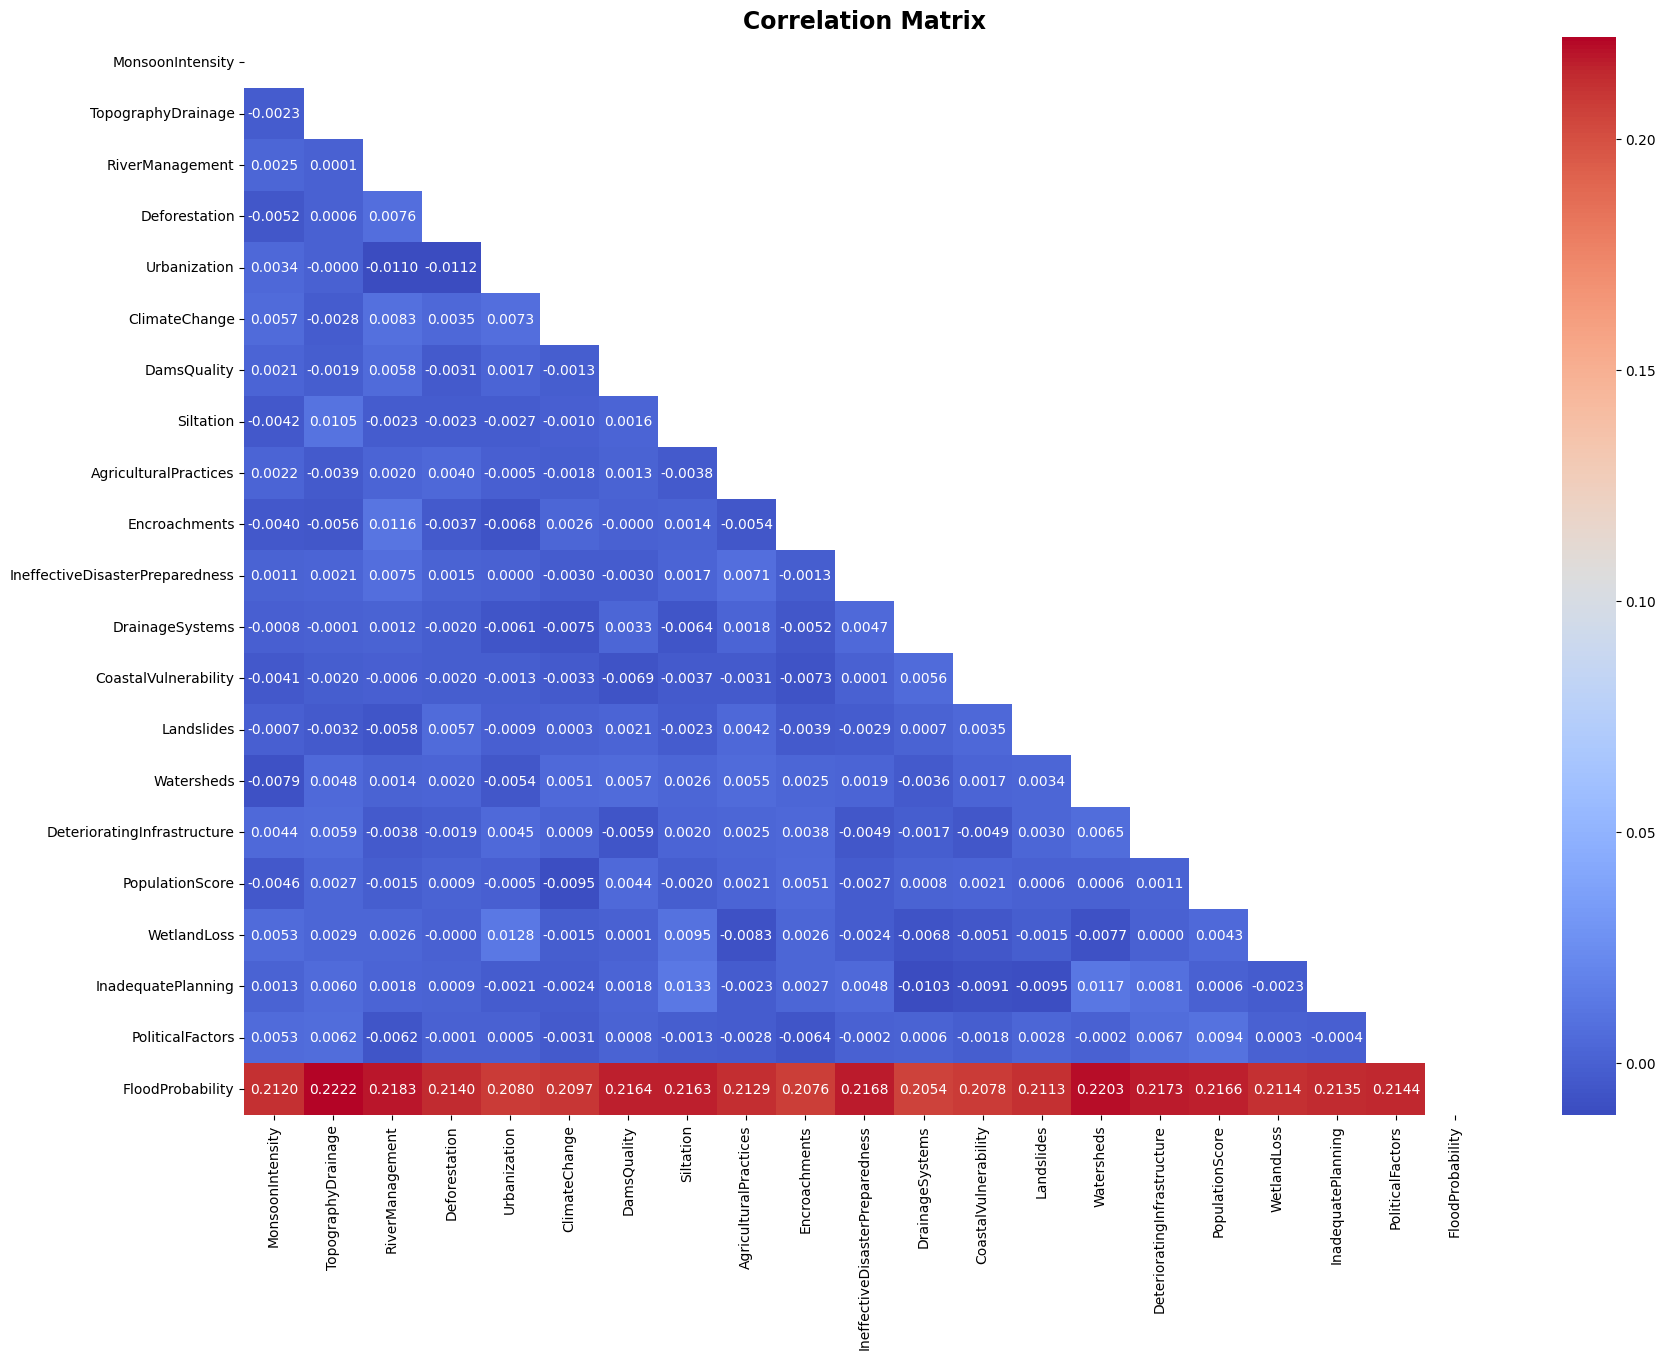

In [16]:
corr_matrix = data.corr(method = "spearman")
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

fig,ax = plt.subplots(figsize = (20,14))
sns.heatmap(corr_matrix, cmap = "coolwarm", annot = True, fmt = ".4f", mask = mask, annot_kws = {'fontsize':10},ax = ax)
ax.set_title("Correlation Matrix", fontsize = 17, fontweight = "bold",color = "black")
fig.show()

In [20]:
X = data.drop("FloodProbability", axis = 1)
y = data["FloodProbability"]

SEED = 42

X_train, X_test, y_train, y_test = tts(X, y,
                                      test_size = 0.3,
                                      random_state = SEED)

In [21]:
binarizer = Binarizer(threshold = 0.5)

y_train_bin = binarizer.fit_transform(y_train.values.reshape(-1,1))
y_test_bin = binarizer.transform(y_test.values.reshape(-1,1))

In [22]:
lr = LogisticRegression(random_state = SEED)
rf = RandomForestClassifier(random_state = SEED)
et = ExtraTreesClassifier(random_state = SEED)
xgb = XGBClassifier(random_state = SEED)
lgbm = LGBMClassifier(random_state = SEED, class_weight = "balanced")
cb = CatBoostClassifier(random_state = SEED, auto_class_weights = "SqrtBalanced", verbose = 0)

In [23]:
# Training !!!

MODELS = [lr, rf, et, xgb, lgbm, cb]

accuracy_train = {}
accuracy_test = {}

for model in tqdm(MODELS):
    name = type(model).__name__
    model.fit(X_train, y_train_bin)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    accuracy_train[name] = accuracy_score(y_train_bin.squeeze(), y_pred_train)
    accuracy_test[name] = accuracy_score(y_test_bin.squeeze(), y_pred_test)
    print(f"* {name} finished")

  0%|          | 0/6 [00:00<?, ?it/s]

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


* LogisticRegression finished


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


* RandomForestClassifier finished


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


* ExtraTreesClassifier finished
* XGBClassifier finished


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Number of positive: 16470, number of negative: 18530
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
* LGBMClassifier finished
* CatBoostClassifier finished


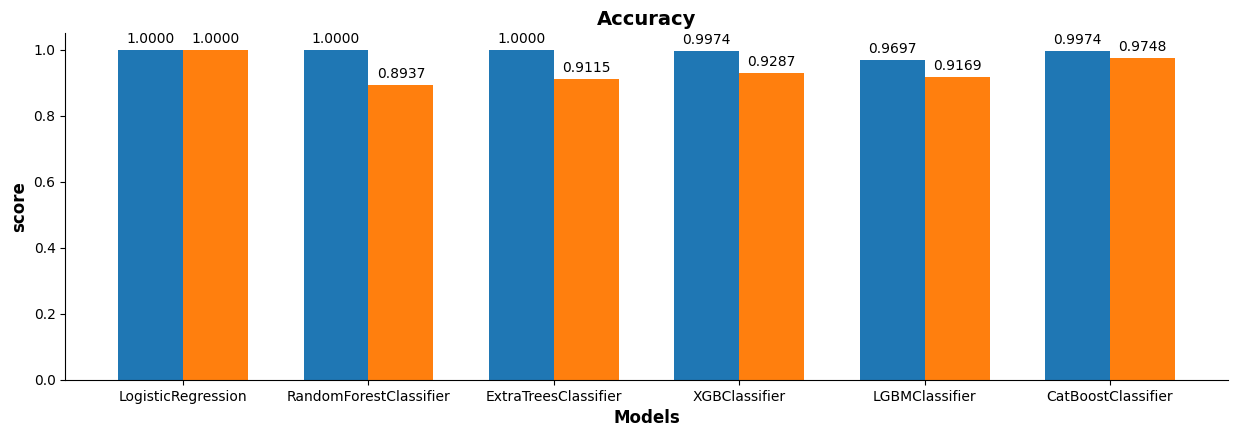

In [24]:
# We visualize the metric on both the training and testing set of each model.
metric_train = pd.DataFrame.from_dict(accuracy_train, orient = 'index').rename(columns = {0:'train'})
metric_test = pd.DataFrame.from_dict(accuracy_test, orient = 'index').rename(columns = {0:'test'})

df_metric = pd.concat([metric_train, metric_test], axis = 1)

labels = df_metric.index.to_list()
values_train = df_metric.iloc[:, 0]
values_test = df_metric.iloc[:, 1]

x = np.arange(len(labels))
width = 0.35

fig,ax = plt.subplots(figsize = (15, 4.5))

rects1 = ax.bar(x = x - width/2, height = values_train, width = width)
rects2 = ax.bar(x = x + width/2, height = values_test, width = width)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title("Accuracy", fontsize = 14, fontweight = "bold")
ax.set_xlabel("Models", fontsize = 12, fontweight = "bold")
ax.set_ylabel("score", fontsize = 12, fontweight = "bold")

ax.set_xticks(x)
ax.set_xticklabels(labels)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(text = f'{height:.4f}',
                    xy = (rect.get_x() + rect.get_width()/2, height),
                    xytext = (0,3),
                    textcoords = "offset points",
                    ha = "center",
                    va = "bottom")

autolabel(rects1)
autolabel(rects2)
fig.show()


In [25]:
model = LogisticRegression(random_state = SEED)
model.fit(X_train, y_train_bin)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(random_state=42)

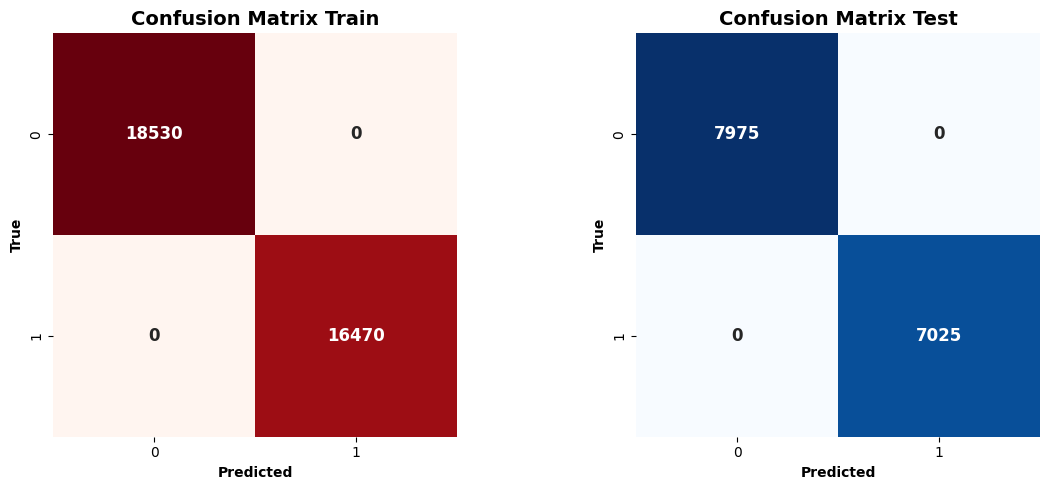

In [26]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

conf_matrix_train = confusion_matrix(y_train_bin.squeeze(), y_pred_train)
conf_matrix_test = confusion_matrix(y_test_bin.squeeze(), y_pred_test)

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
ax = ax.flat

sns.heatmap(conf_matrix_train, cmap = "Reds", annot = True, annot_kws = {'fontsize':12, 'fontweight':'bold'}, fmt = "", cbar = False, square = True, ax = ax[0])
ax[0].set_xlabel("Predicted", fontsize = 10, fontweight = "bold", color = "black")
ax[0].set_ylabel("True", fontsize = 10, fontweight = "bold", color = "black")
ax[0].set_title("Confusion Matrix Train", fontsize = 14, fontweight = "bold", color = "black")

sns.heatmap(conf_matrix_test, cmap = "Blues", annot = True, annot_kws = {'fontsize':12, 'fontweight':'bold'}, fmt = "", cbar = False, square = True, ax = ax[1])
ax[1].set_xlabel("Predicted", fontsize = 10, fontweight = "bold", color = "black")
ax[1].set_ylabel("True", fontsize = 10, fontweight = "bold", color = "black")
ax[1].set_title("Confusion Matrix Test", fontsize = 14, fontweight = "bold", color = "black")

fig.tight_layout()
fig.show()

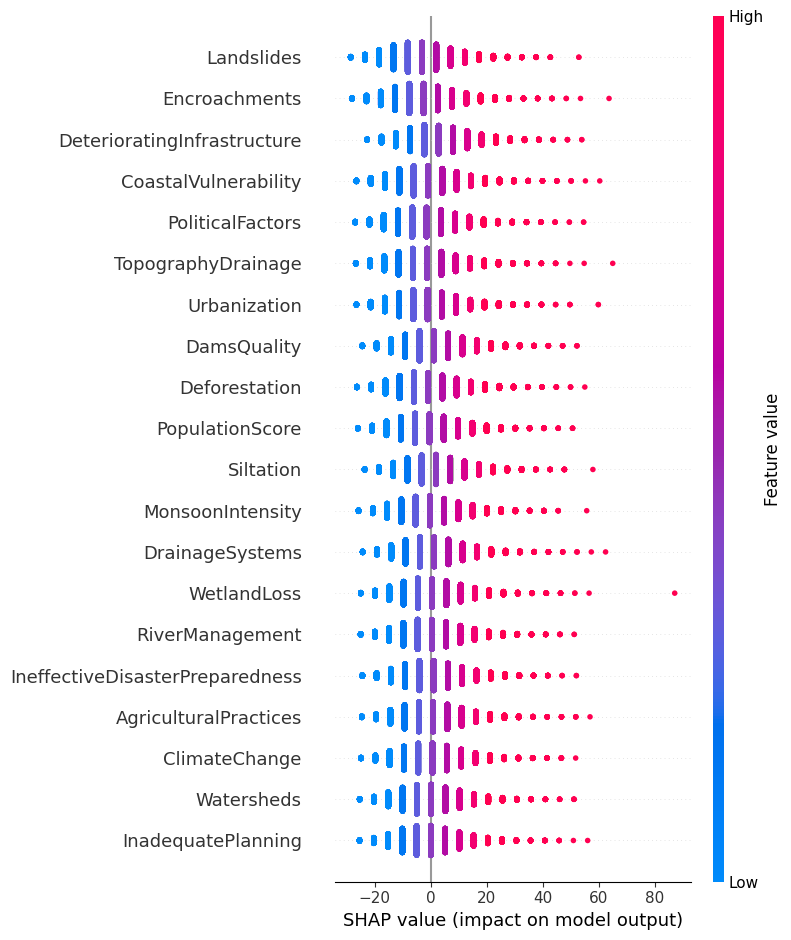

In [27]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.initjs()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

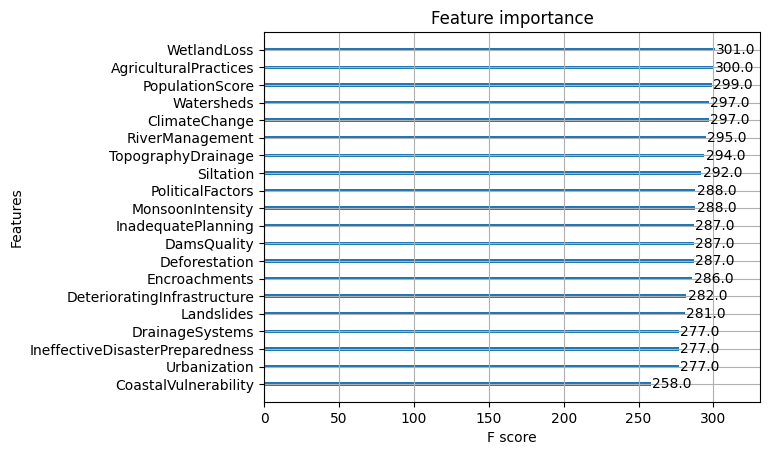

In [31]:
plot_importance(xgb)